In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud as wc
import re, string
from scipy import stats
import datetime
from collections import Counter
import sqlite3

In [3]:
conn = sqlite3.connect('amazon_monitor.db')
df = pd.read_excel('data2.xlsx')

In [4]:
df.head()

,id,page,page_order,rating_count,price,brand,goods_spcs,refresh_rate,size,avg_rating,star5_rating,star4_rating,star3_rating,star2_rating,star1_rating,review_key_word,pro_date,item_url
0,B09K3FWMPL,1,0,"1,050 ratings",$199.99,InnoView,['Gaming'],['60 Hz'],['15.6 Feet'],"['4.5 out of 5 stars', '4.5 out of 5 stars']",['5 stars represent 76% of rating'],['4 stars represent 12% of rating'],['3 stars represent 3% of rating'],['2 stars represent 3% of rating'],['1 stars represent 6% of rating'],NaN,"October22,2021",https://www.amazon.com/gp/slredirect/picassoRe...
1,B09237LL5Q,1,1,"1,136 ratings",$199.99,ViewSonic,"['Personal, Education, Business']",['60 Hz'],['15.6 Inches'],"['4.5 out of 5 stars', '4.5 out of 5 stars']",['5 stars represent 75% of rating'],['4 stars represent 14% of rating'],['3 stars represent 4% of rating'],['2 stars represent 2% of rating'],['1 stars represent 5% of rating'],"['touch screen', 'macbook pro', 'usb-c cable',...","April8,2021",https://www.amazon.com/gp/slredirect/picassoRe...
2,B0773ZY26F,1,2,"17,468 ratings",$125.00,Sceptre,"['Multimedia, Personal, Business']",['60 Hz'],['24 Inches'],"['4.6 out of 5 stars', '4.6 out of 5 stars']",['5 stars represent 77% of rating'],['4 stars represent 14% of rating'],['3 stars represent 4% of rating'],['2 stars represent 1% of rating'],['1 stars represent 3% of rating'],"['picture quality', 'dead pixels', 'home offic...","November1,2017",https://www.amazon.com/Sceptre-E248W-19203R-Mo...
3,B078HMK7S3,1,3,"1,428 ratings",$115.63,Sceptre,"['Business, home, office and gaming']",['75 Hz'],['20 Inches'],"['4.4 out of 5 stars', '4.4 out of 5 stars']",['5 stars represent 66% of rating'],['4 stars represent 17% of rating'],['3 stars represent 8% of rating'],['2 stars represent 3% of rating'],['1 stars represent 5% of rating'],"['works great', 'picture quality', 'work from ...","December19,2017",https://www.amazon.com/Sceptre-Monitor-1600x90...
4,B07743412C,1,4,"20,820 ratings",$99.99,Sceptre,"['Multimedia, Personal, Business']",['60 Hz'],['20 Inches'],"['4.5 out of 5 stars', '4.5 out of 5 stars']",['5 stars represent 73% of rating'],['4 stars represent 16% of rating'],['3 stars represent 6% of rating'],['2 stars represent 2% of rating'],['1 stars represent 4% of rating'],"['picture quality', 'working from home', 'easy...","November1,2017",https://www.amazon.com/Sceptre-E205W-16003R-Fr...


# 數值處理

In [5]:
#由 1 開始排列
df['page_order'] = df['page_order']+1

In [6]:


#評論數量
df['rating_count'] = df['rating_count'].str.extract('((?:[\d,])+)', expand=False)
new_rating_count = []
for rating_count in df['rating_count']:
    rating_count = int(re.sub(',','',rating_count))
    new_rating_count.append(rating_count)
df['rating_count'] = new_rating_count

#從字段提取資料並轉變成數值
df['refresh_rate'] = pd.to_numeric(df['refresh_rate'].str.extract('(\d+)', expand=False))
df['price'] = pd.to_numeric(df['price'].str.extract('((?:[\d.])+)', expand=False))
df['size'] = pd.to_numeric(df['size'].str.extract('((?:[\d.])+)', expand=False))
df['avg_rating'] = pd.to_numeric(df['avg_rating'].str.extract('(\d.\d)', expand=False))

#str to date 
df['pro_date'] = pd.to_datetime(df['pro_date'], format='%B%d,%Y')

In [7]:
#5-1星評論比例

for rating_column in df.columns[10:15]:
    df[rating_column] = df[rating_column].str.extract('(\d*%)', expand = False)
    df[rating_column] = df[rating_column].str.strip('%').astype(float)/100


In [8]:
df['item_price_high'] = df['price'].apply(lambda x: 1 if x>= 330 else 0)
df['item_price_mid'] = df['price'].apply(lambda x: 1 if 160 <= x < 330 else 0)
df['item_price_low'] = df['price'].apply(lambda x: 1 if x < 160 else 0)



In [9]:
df.head()

,id,page,page_order,rating_count,price,brand,goods_spcs,refresh_rate,size,avg_rating,...,star4_rating,star3_rating,star2_rating,star1_rating,review_key_word,pro_date,item_url,item_price_high,item_price_mid,item_price_low
0,B09K3FWMPL,1,1,1050,199.99,InnoView,['Gaming'],60.0,15.6,4.5,...,0.12,0.03,0.03,0.06,NaN,2021-10-22,https://www.amazon.com/gp/slredirect/picassoRe...,0,1,0
1,B09237LL5Q,1,2,1136,199.99,ViewSonic,"['Personal, Education, Business']",60.0,15.6,4.5,...,0.14,0.04,0.02,0.05,"['touch screen', 'macbook pro', 'usb-c cable',...",2021-04-08,https://www.amazon.com/gp/slredirect/picassoRe...,0,1,0
2,B0773ZY26F,1,3,17468,125.00,Sceptre,"['Multimedia, Personal, Business']",60.0,24.0,4.6,...,0.14,0.04,0.01,0.03,"['picture quality', 'dead pixels', 'home offic...",2017-11-01,https://www.amazon.com/Sceptre-E248W-19203R-Mo...,0,0,1
3,B078HMK7S3,1,4,1428,115.63,Sceptre,"['Business, home, office and gaming']",75.0,20.0,4.4,...,0.17,0.08,0.03,0.05,"['works great', 'picture quality', 'work from ...",2017-12-19,https://www.amazon.com/Sceptre-Monitor-1600x90...,0,0,1
4,B07743412C,1,5,20820,99.99,Sceptre,"['Multimedia, Personal, Business']",60.0,20.0,4.5,...,0.16,0.06,0.02,0.04,"['picture quality', 'working from home', 'easy...",2017-11-01,https://www.amazon.com/Sceptre-E205W-16003R-Fr...,0,0,1


In [10]:
df.describe()

,page,page_order,rating_count,price,refresh_rate,size,avg_rating,star5_rating,star4_rating,star3_rating,star2_rating,star1_rating,item_price_high,item_price_mid,item_price_low
count,1614.000000,1614.000000,1614.000000,939.000000,1303.000000,1576.000000,1150.000000,1130.000000,1025.000000,902.000000,802.000000,925.000000,1614.000000,1614.000000,1614.000000
mean,39.214994,15.775713,564.959108,274.240767,89.066769,22.680914,4.362000,0.706867,0.161112,0.074157,0.051758,0.083514,0.139405,0.289963,0.152416
std,22.991931,7.796259,2017.328020,186.898560,46.847640,25.370601,0.452793,0.147511,0.103360,0.074858,0.087406,0.085070,0.346476,0.453885,0.359535
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.100000,1.000000,0.180000,0.020000,0.010000,0.010000,0.010000,0.000000,0.000000,0.000000
25%,19.000000,9.000000,0.000000,159.480000,60.000000,15.600000,4.200000,0.630000,0.110000,0.040000,0.020000,0.040000,0.000000,0.000000,0.000000
50%,39.000000,17.000000,25.000000,229.990000,75.000000,22.000000,4.500000,0.730000,0.140000,0.050000,0.030000,0.060000,0.000000,0.000000,0.000000
75%,59.000000,23.000000,230.750000,328.990000,76.000000,27.000000,4.600000,0.790000,0.180000,0.090000,0.060000,0.100000,0.000000,1.000000,0.000000
max,79.000000,30.000000,37756.000000,999.990000,360.000000,685.800000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 文字欄處理

In [11]:
#brand欄 看似List 其實是str 

new_brand_list = []
for brand in df['brand']:
    brand = re.sub(r'[\'\[\]\s]','',brand).lower()
    new_brand_list.append(brand)    
df['brand'] = new_brand_list

In [12]:
#good_spcs及 review_key一樣是str
#good_spcs及 review_key 都是多對 1個id，把它們分開到不同表

goods_spcs_list = []
id4spcs_list = []

review_key_list = []
id4review_list = []

#nan 是 float 沒辦法用re去處理，所以轉為字串
df['review_key_word'] = df['review_key_word'].fillna('-NA')

#id沒有缺失值所以用id的長度來range
#去除非分隔符號、統一分隔符號及都轉為小寫
for row_num in range(len(df['id'])):
    item_id = df['id'][row_num]
    goods_spcs = re.sub(r"['\[\]\s]","",df['goods_spcs'][row_num].lower())
    goods_spcs = re.sub(r'[，;]',',',goods_spcs)
    goods_spcs = goods_spcs.split(',')
    for each_goods_spcs in goods_spcs:
        id4spcs_list.append(item_id)
        if each_goods_spcs == '':
            each_goods_spcs = 'not_mention'
        goods_spcs_list.append(each_goods_spcs)
        
    if df['review_key_word'][row_num] == None:
        continue
    items_review_key = re.sub(r"['\[\]\s]","",df['review_key_word'][row_num].lower())
    items_review_key = items_review_key[1:].split(',')
    for each_review_key in items_review_key:
        id4review_list.append(item_id)
        review_key_list.append(each_review_key)
        


# 分割不同DF

In [13]:
#把原df資料分成3個表 df_item_spcs, df_item_review, df_item_basic_info
#再存回資料庫(如有)

In [14]:
df_item_spcs = pd.DataFrame( zip(id4spcs_list, goods_spcs_list), columns = ['id','goods_spcs'])
df_item_spcs


,id,goods_spcs
0,B09K3FWMPL,gaming
1,B09237LL5Q,personal
2,B09237LL5Q,education
3,B09237LL5Q,business
4,B0773ZY26F,multimedia
...,...,...
2676,B07YDZPBHD,not_mention
2677,B07PLJZ5QH,not_mention
2678,B085723X2N,not_mention
2679,B08BJ2SFCP,not_mention


In [15]:
df_item_review = pd.DataFrame( zip(id4review_list, review_key_list), columns = ['id','review_key'])
df_item_review



,id,review_key
0,B09K3FWMPL,na
1,B09237LL5Q,ouchscreen
2,B09237LL5Q,macbookpro
3,B09237LL5Q,usb-ccable
4,B09237LL5Q,picturequality
...,...,...
15049,B07YDZPBHD,na
15050,B07PLJZ5QH,na
15051,B085723X2N,na
15052,B08BJ2SFCP,na


In [16]:
df_item_basic_info = df.drop(['goods_spcs', 'review_key_word'], axis = 1)
df_item_basic_info


,id,page,page_order,rating_count,price,brand,refresh_rate,size,avg_rating,star5_rating,star4_rating,star3_rating,star2_rating,star1_rating,pro_date,item_url,item_price_high,item_price_mid,item_price_low
0,B09K3FWMPL,1,1,1050,199.99,innoview,60.0,15.6,4.5,0.76,0.12,0.03,0.03,0.06,2021-10-22,https://www.amazon.com/gp/slredirect/picassoRe...,0,1,0
1,B09237LL5Q,1,2,1136,199.99,viewsonic,60.0,15.6,4.5,0.75,0.14,0.04,0.02,0.05,2021-04-08,https://www.amazon.com/gp/slredirect/picassoRe...,0,1,0
2,B0773ZY26F,1,3,17468,125.00,sceptre,60.0,24.0,4.6,0.77,0.14,0.04,0.01,0.03,2017-11-01,https://www.amazon.com/Sceptre-E248W-19203R-Mo...,0,0,1
3,B078HMK7S3,1,4,1428,115.63,sceptre,75.0,20.0,4.4,0.66,0.17,0.08,0.03,0.05,2017-12-19,https://www.amazon.com/Sceptre-Monitor-1600x90...,0,0,1
4,B07743412C,1,5,20820,99.99,sceptre,60.0,20.0,4.5,0.73,0.16,0.06,0.02,0.04,2017-11-01,https://www.amazon.com/Sceptre-E205W-16003R-Fr...,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609,B07YDZPBHD,79,12,0,NaN,viewsonic,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-11,https://www.amazon.com/ViewSonic-VPC12-Wpo-6-S...,0,0,0
1610,B07PLJZ5QH,79,13,0,NaN,innovativeofficeproductsinc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-05,https://www.amazon.com/Innovative-Office-Produ...,0,0,0
1611,B085723X2N,79,16,0,NaN,avic,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,2018-08-26,https://www.amazon.com/AVIC-Panel-TMS150XG1-10...,0,0,0
1612,B08BJ2SFCP,79,17,0,NaN,dell,60.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,2020-06-19,https://www.amazon.com/Dell-E2720H-LCD-Monitor...,0,0,0


## goods_spcs處理

In [17]:
#統計goods_spcs類別數量
df_goods_type_count = pd.value_counts(df_item_spcs['goods_spcs'])
df_goods_type_count

not_mention            747
gaming                 478
business               466
personal               433
multimedia             120
                      ... 
advertising              1
professionalcolor        1
personalandbusiness      1
school                   1
monitors                 1
Name: goods_spcs, Length: 77, dtype: int64

In [18]:
#goods_spcs名目太多，做一個統整
#goods_spcs有一半是沒有分類，之後可以做一個classification model

In [19]:
#把離群值轉成other
df_item_spcs = df_item_spcs.replace(df_goods_type_count[df_goods_type_count<10].index,'other')

In [20]:
df_goods_type_count = pd.value_counts(df_item_spcs['goods_spcs'])
df_goods_type_count

not_mention     747
gaming          478
business        466
personal        433
other           137
multimedia      120
education        85
videoediting     76
photoediting     70
programming      69
Name: goods_spcs, dtype: int64

## item_review處理

In [21]:
df_review_key_count = pd.value_counts(df_item_review['review_key'])
df_review_key_count

na                    981
picturequality        320
greatmonitor          276
highlyrecommend       241
displayport           174
                     ... 
mustbeoverclocked       1
integratedspeakers      1
dooreffect              1
choice                  1
lightandthin            1
Name: review_key, Length: 2412, dtype: int64

圖表

In [22]:
df_by_brand_sum = df.groupby('brand').sum()
df_by_brand_sum['total'] = df_by_brand_sum['item_price_low']+df_by_brand_sum['item_price_mid']+df_by_brand_sum['item_price_high']
df_item_over_7 = df_by_brand_sum[df_by_brand_sum['total']>7]

df_by_brand_avg = df.groupby('brand').mean()

In [23]:
df_low_price = df[df['item_price_low']==1]
df_mid_price = df[df['item_price_mid']==1]
df_high_price = df[df['item_price_high']==1]


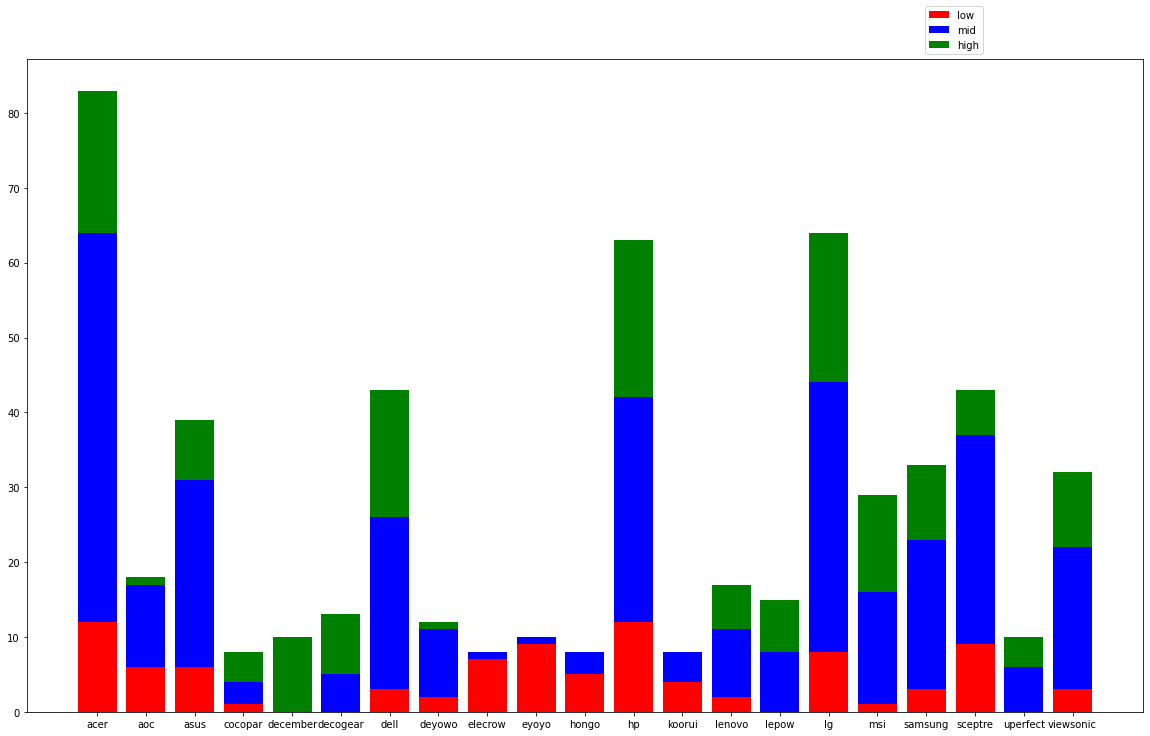

In [24]:
fig = plt.figure(figsize=(20,12)) 
plt.bar(df_item_over_7.index,df_item_over_7['item_price_low'],color = 'red', label = "low")
plt.bar(df_item_over_7.index,df_item_over_7['item_price_mid'],color = 'blue', label = "mid", bottom=np.array(df_item_over_7['item_price_low']))
plt.bar(df_item_over_7.index,df_item_over_7['item_price_high'],color = 'green', label = "high", bottom=np.array(df_item_over_7['item_price_low'])+np.array(df_item_over_7['item_price_mid']))
plt.legend(loc="lower left",bbox_to_anchor=(0.8,1.0))
plt.show()

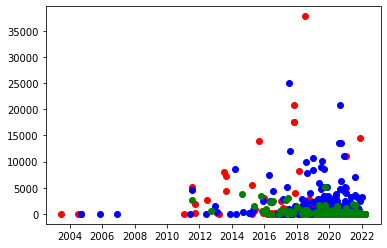

In [25]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df_low_price['pro_date'], df_low_price['rating_count'], color = 'r')
ax.scatter(df_mid_price['pro_date'], df_mid_price['rating_count'], color = 'b')
ax.scatter(df_high_price['pro_date'], df_high_price['rating_count'], color = 'g')
plt.show() 

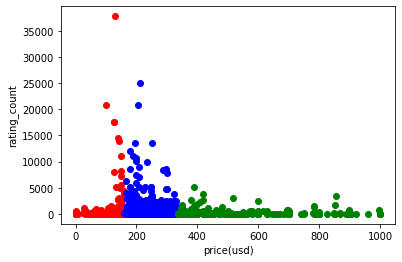

In [26]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df_low_price['price'], df_low_price['rating_count'], color = 'r')
ax.scatter(df_mid_price['price'], df_mid_price['rating_count'], color = 'b')
ax.scatter(df_high_price['price'], df_high_price['rating_count'], color = 'g')
plt.xlabel('price(usd)')
plt.ylabel('rating_count')
plt.show() 

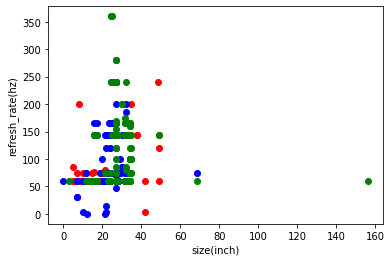

In [28]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df_low_price['size'], df_low_price['refresh_rate'], color = 'r')
ax.scatter(df_mid_price['size'], df_mid_price['refresh_rate'], color = 'b')
ax.scatter(df_high_price['size'], df_high_price['refresh_rate'], color = 'g')
plt.xlabel('size(inch)')
plt.ylabel('refresh_rate(hz)')
plt.show() 

In [123]:
df_by_brand_avg.describe()

,page,page_order,rating_count,price,refresh_rate,size,avg_rating,star5_rating,star4_rating,star3_rating,star2_rating,star1_rating,item_price_high,item_price_mid,item_price_low
count,240.000000,240.000000,240.000000,204.000000,182.000000,226.000000,185.000000,179.000000,160.000000,142.000000,138.000000,147.000000,240.000000,240.000000,240.000000
mean,38.106824,14.932110,195.084412,222.355696,76.394024,16.644543,4.222004,0.669674,0.197754,0.104902,0.087327,0.127668,0.133969,0.296907,0.355484
std,20.471512,6.464041,471.136461,151.864741,34.816411,8.380624,0.560978,0.163976,0.141326,0.108430,0.140442,0.142249,0.291648,0.390643,0.445035
min,1.000000,1.000000,0.000000,1.000000,2.000000,3.000000,1.000000,0.250000,0.070000,0.020000,0.010000,0.020000,0.000000,0.000000,0.000000
25%,23.000000,10.000000,1.000000,125.531667,60.000000,12.075000,4.033333,0.575000,0.133229,0.058125,0.030000,0.060000,0.000000,0.000000,0.000000
50%,32.357143,15.215909,18.500000,189.640000,60.000000,15.600000,4.300000,0.675000,0.160000,0.080000,0.050000,0.085974,0.000000,0.000000,0.000000
75%,54.000000,18.500000,140.250000,299.350256,75.000000,19.958333,4.500000,0.750128,0.211667,0.111250,0.080000,0.133333,0.008621,0.500000,1.000000
max,79.000000,30.000000,3246.500000,950.389000,240.000000,84.650000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [80]:
df_avg_over_7 = df_by_brand_avg.drop(index = set(df_by_brand_avg.index) - set(df_item_over_7.index))
df_avg_over_7
df_avg_over_7 = df_avg_over_7.sort_values(by= ['rating_count'])

<BarContainer object of 21 artists>

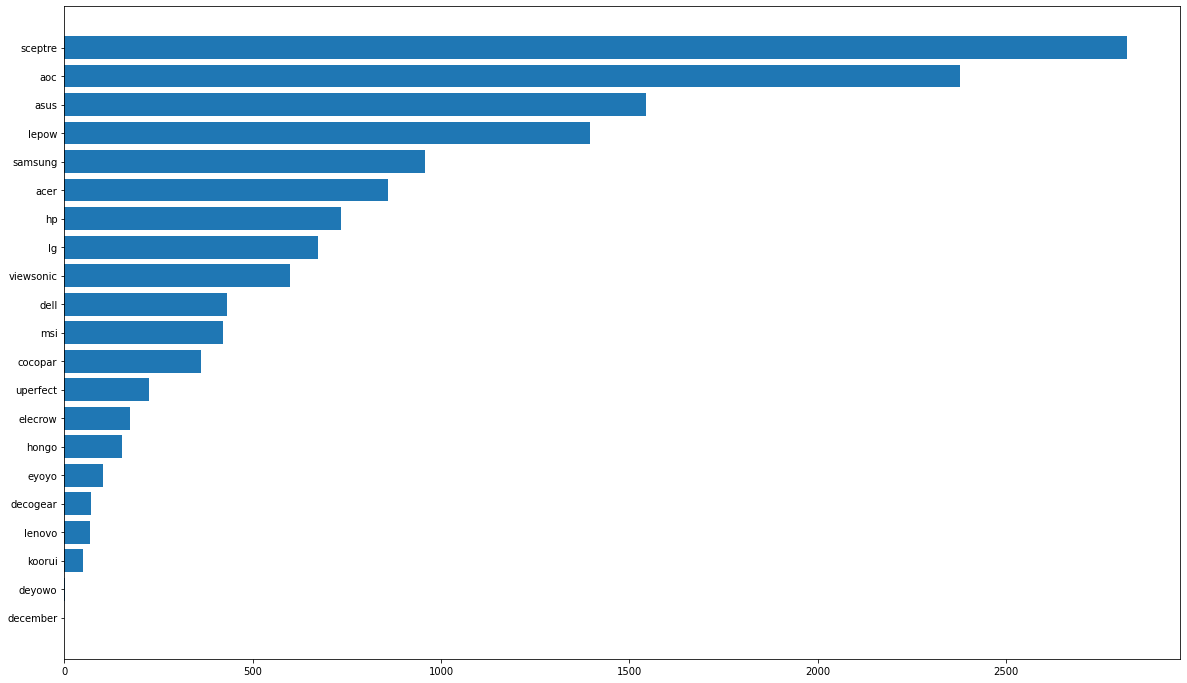

In [81]:
fig = plt.figure(figsize=(20,12)) 

plt.barh(df_avg_over_7.index,df_avg_over_7['rating_count'])

<BarContainer object of 21 artists>

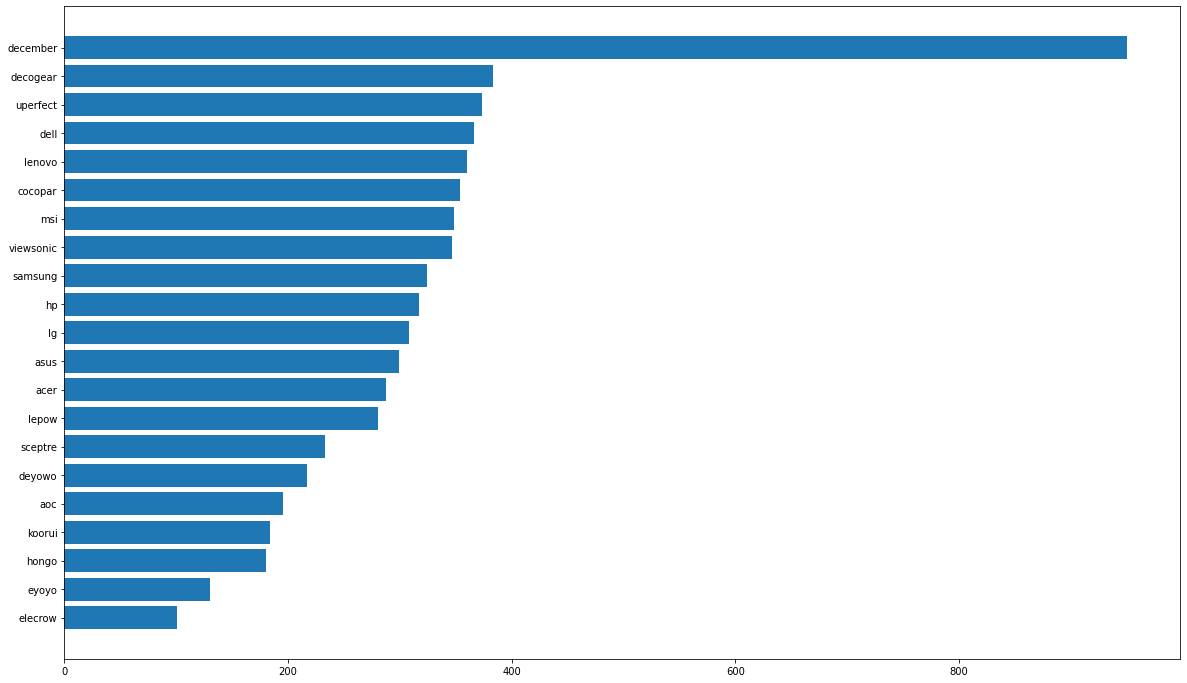

In [82]:
df_avg_over_7 = df_avg_over_7.sort_values(by= ['price'])
fig = plt.figure(figsize=(20,12))
plt.barh(df_avg_over_7.index,df_avg_over_7['price'])

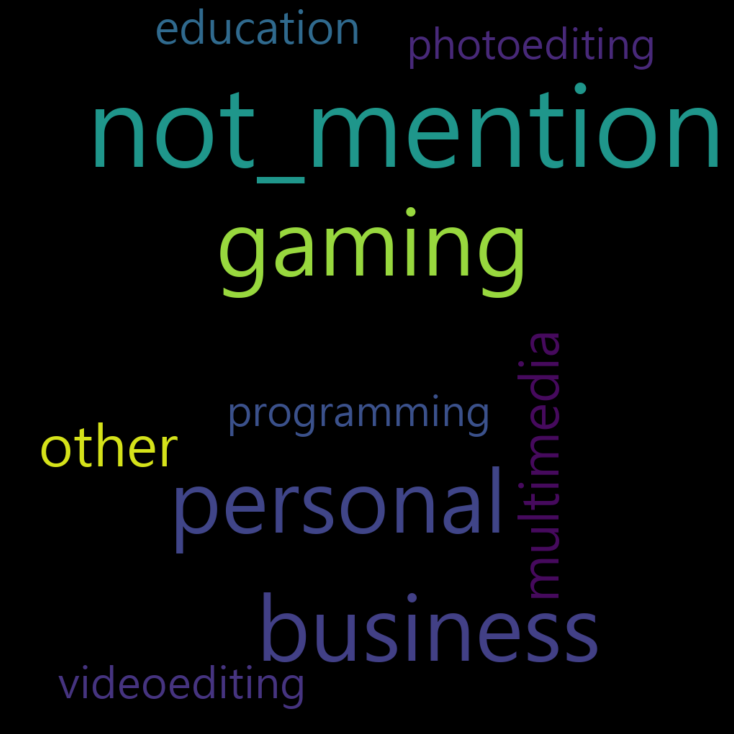

In [69]:
font = r'msjh.ttc'

#想要文字雲出現的圖示
#mask = np.array(Image.open())
 
my_wordcloud = wc(background_color="black",font_path=font,collocations=False, width=1000, height=1000, margin=2)  
my_wordcloud.generate_from_frequencies(frequencies=Counter(df_item_spcs['goods_spcs']))

#產生圖片
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(my_wordcloud,interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
#顯示用
plt.show()

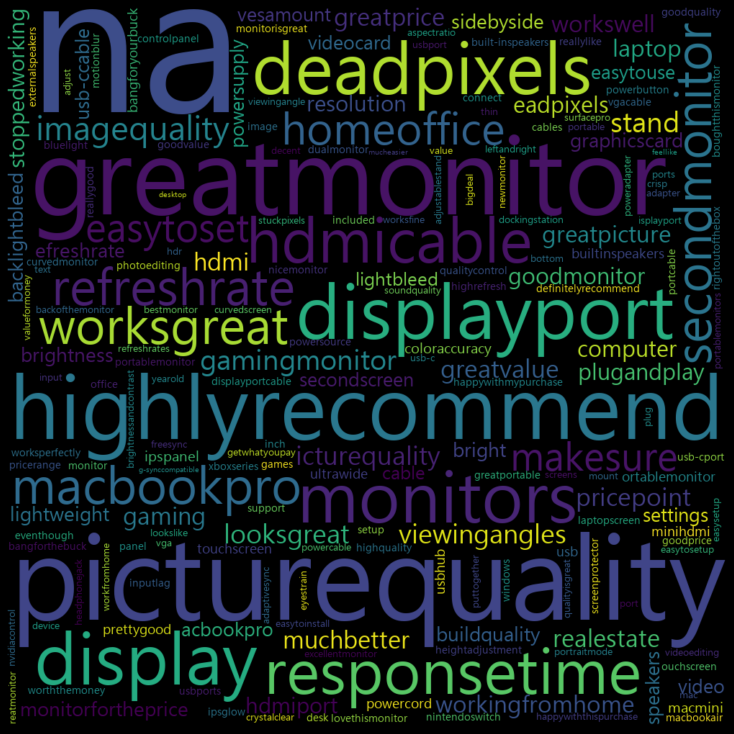

In [67]:
my_wordcloud.generate_from_frequencies(frequencies=Counter(df_item_review['review_key']))

#產生圖片
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(my_wordcloud,interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
#顯示用
plt.show()

In [62]:
#存回sqlite
#df_item_spcs.to_sql('item_spcs', conn, if_exists='append', index=False)
#df_item_review.to_sql('item_review', conn, if_exists='append', index=False)
#df_item_basic_info.to_sql('items_basic_info', conn, if_exists='append', index=False)